# Описание проекта

* **Сфера деятельности**: сервис такси

* **Цель**: спрогнозировать количество заказов такси на следующий час.

* **Ключевые критерии качества модели** (в порядке приоритетности):
    - качество предсказания (**на тестовой выборке (10%) метрика RMSE < 48**)
    - время обучения модели
    - время предсказания модели

* **Задачи**:
    - Загрузить данные и  выполните их ресемплирование по одному часу;
    - Проанализировать данные;
    - Обучить разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.;
    - Провеить данные на тестовой выборке и сделайте выводы.

## Описание данных:
* **`num_orders`** - число заказов.

In [203]:
#! pip install pmdarima

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import time

from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, mean_squared_error as mse

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка и обработка данных.

### 1.1 Загрузка данных

In [205]:
try:
    try:
        df = pd.read_csv('taxi.csv')
    except:
        df = pd.read_csv('/datasets/taxi.csv')

    print('Вывод первых 5 строк из таблицы с данными.')
    display(df.head())
    print()
    print('Загрузка файла прошла успешно!!!')
except:
    print('При загрузке данных произошла ошибка. Проверьте наличие файла и/или путь к нему.')

Вывод первых 5 строк из таблицы с данными.


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



Загрузка файла прошла успешно!!!


### 1.2 Обработка данных

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Необходимо поменять тип данных в столбце `datetime` и привести данные к временному ряду (дату сделать индексом).

#### 1.2.1 Изменение типа данных

In [207]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


#### 1.2.2 Замена индексов

In [208]:
df = df.set_index('datetime', drop = True).sort_index()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


#### 1.2.3 Ресемплирование по одному часу

In [209]:
df = df.resample("1H").sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## 2. Анализ временного ряда

### 2.1 Тренд, сезонность, остатки

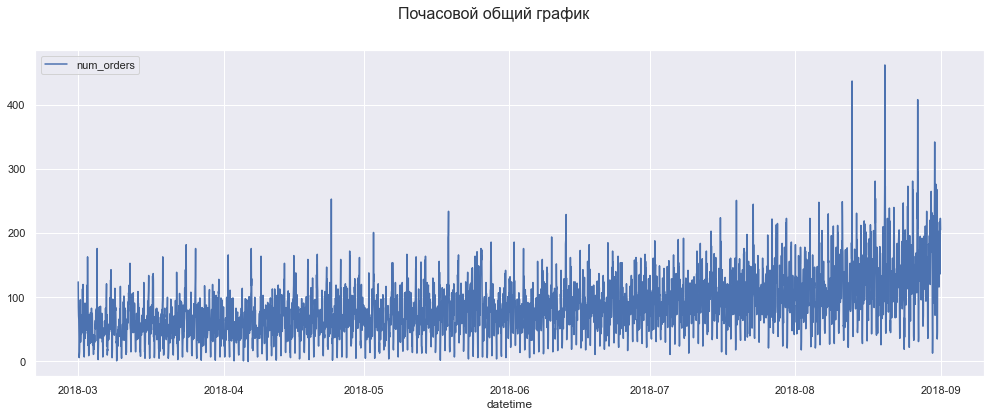

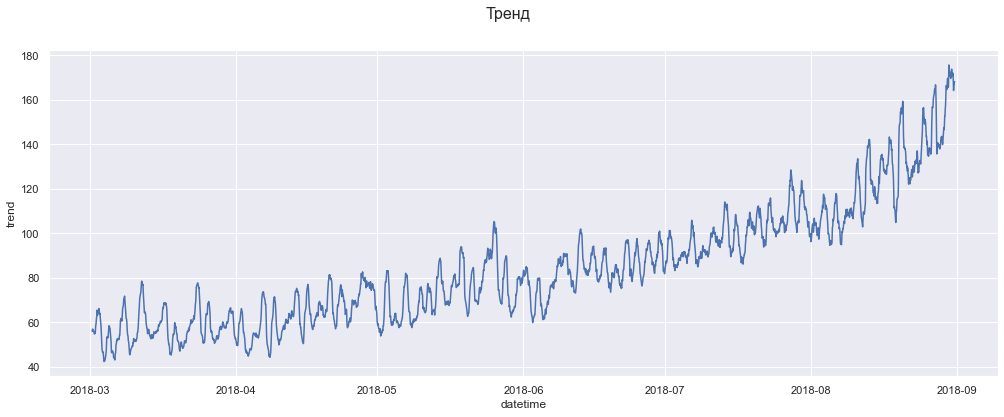

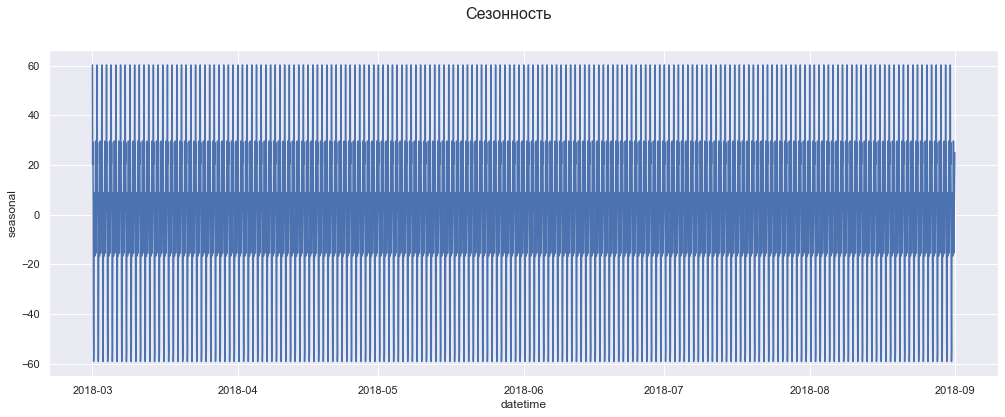

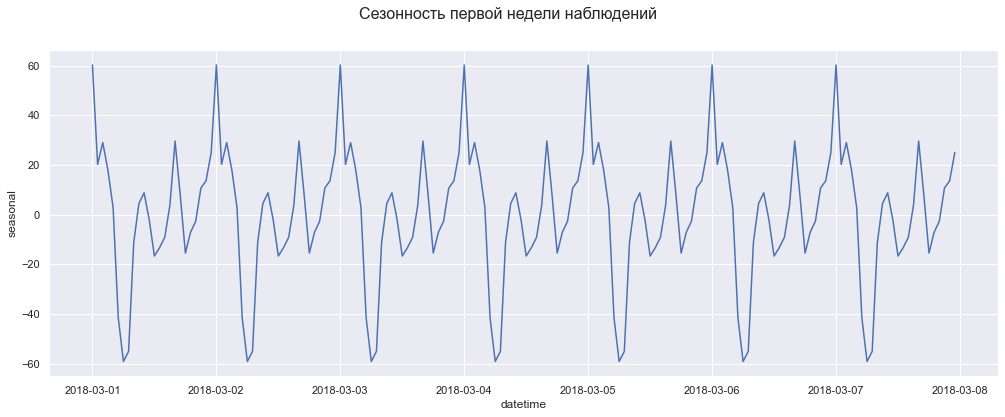

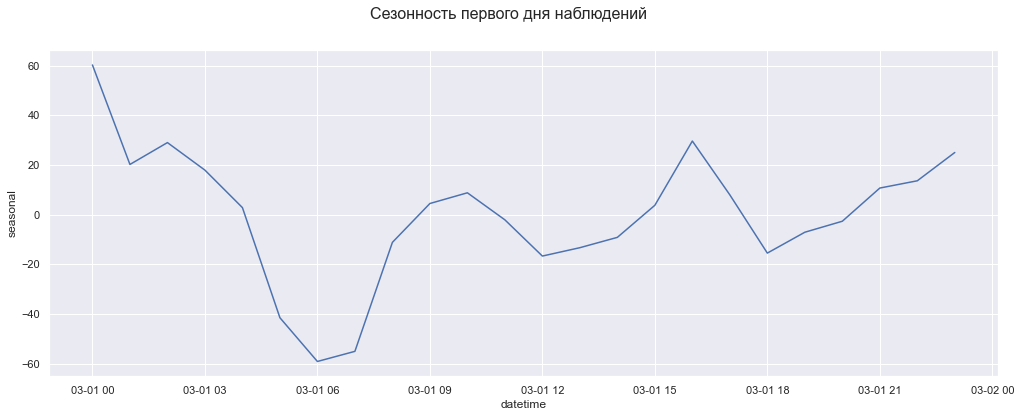

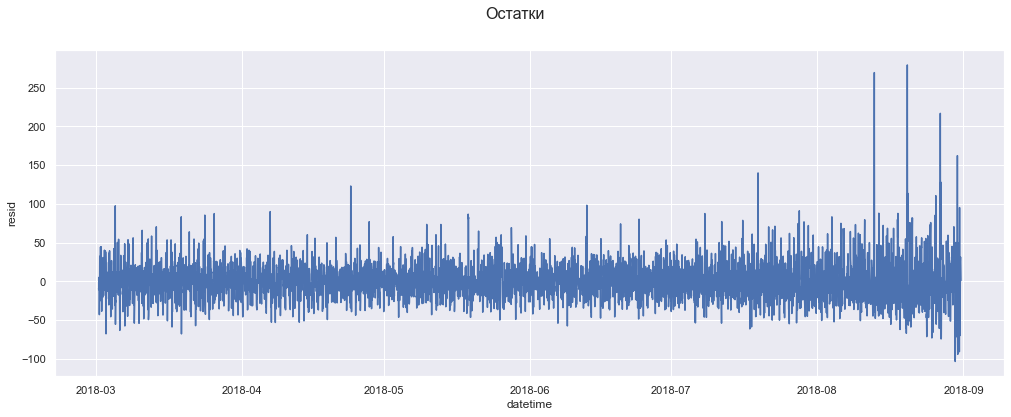

In [210]:
decomp_df = seasonal_decompose(df)

def ts_graph(df, title=None):
    fig = plt.figure(figsize=(17, 6))
    sns.lineplot(data=df)
    fig.suptitle(title, fontsize=16)
    plt.show()
    
    return None

ts_graph(df, title="Почасовой общий график")
ts_graph(decomp_df.trend, "Тренд")
ts_graph(decomp_df.seasonal, "Сезонность")
ts_graph(decomp_df.seasonal.head(24*7), "Сезонность первой недели наблюдений")
ts_graph(decomp_df.seasonal.head(24), "Сезонность первого дня наблюдений")
ts_graph(decomp_df.resid, "Остатки")

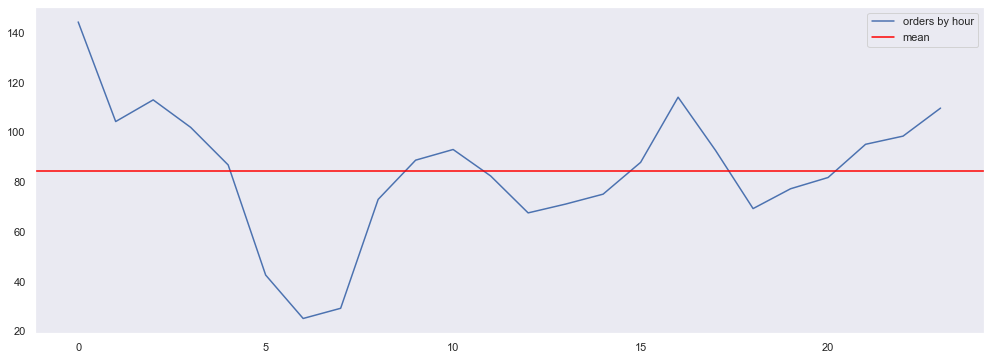

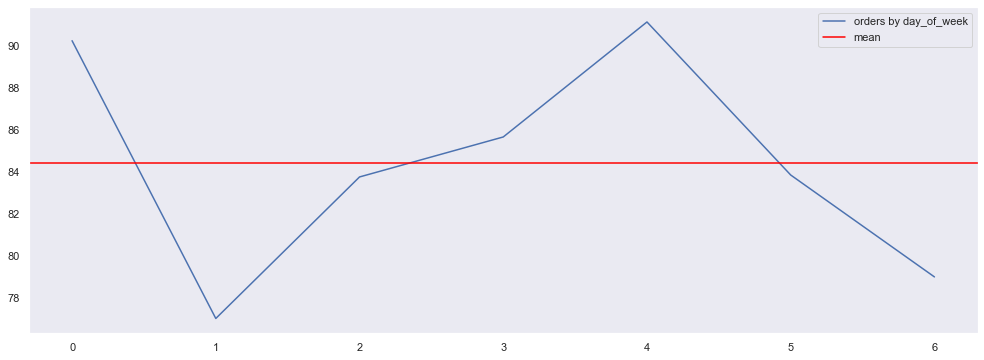

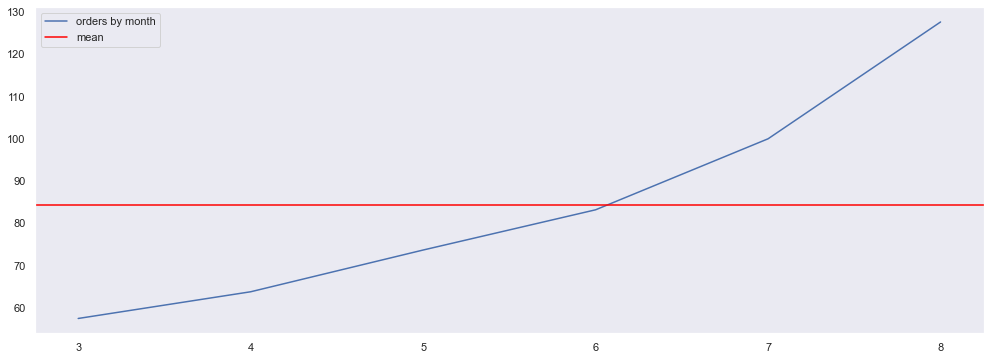

In [211]:
df_help = df.copy()
df_help['hour'] = df_help.index.hour
df_help['day_of_week'] = df_help.index.dayofweek
df_help['month'] = df_help.index.month

def orders_by_time_graph(col):
    plt.figure(figsize=(17, 6))
    plt.plot(df_help.pivot_table(index = col, values = 'num_orders', aggfunc = 'mean'))
    plt.axhline(df_help['num_orders'].mean(), color = 'red')
    plt.legend([f'orders by {col}', 'mean'])
    plt.grid()
    plt.show()

orders_by_time_graph('hour')
orders_by_time_graph('day_of_week')
orders_by_time_graph('month')

* Временной ряд имеет растущий тренд
* Наблюдается сезонность в пределах недели
* Остатки выглядят как стационарный ряд
* Наблюдается вариация числа заказов по времени (часам, дням неделям и месяцам). Это стоит учесть при построении моделей.

In [212]:
df_help.pivot_table(index = 'day_of_week', columns = 'hour', values = 'num_orders', aggfunc = 'sum')

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,4383,3534,3876,3075,2715,1285,661,785,1951,2501,...,1930,2545,2805,2407,1746,2054,1700,2253,2346,2444
1,3108,2573,2294,2467,1899,971,603,927,1762,2086,...,1828,2212,2649,2296,1798,1932,1897,2354,2026,2846
2,3576,2123,2798,2381,2137,1051,910,817,1946,2277,...,2067,2074,3102,2348,1667,2362,2423,2653,2442,2918
3,3971,2728,3289,3133,2508,1108,390,705,2032,2553,...,1729,2237,3275,2790,1928,1689,2213,2685,2511,3055
4,3933,2617,3044,2250,2280,990,853,829,2040,2522,...,2094,2090,3175,2874,2344,2166,2790,3057,3950,3169
5,4417,3458,3227,2835,2340,1286,675,701,2005,2489,...,1985,2572,2939,1972,1620,2030,1952,2089,2199,2504
6,3182,2170,2277,2631,2112,1153,540,622,1705,1917,...,2197,2452,3058,2374,1659,1997,2087,2428,2650,3261


<AxesSubplot:xlabel='hour', ylabel='day_of_week'>

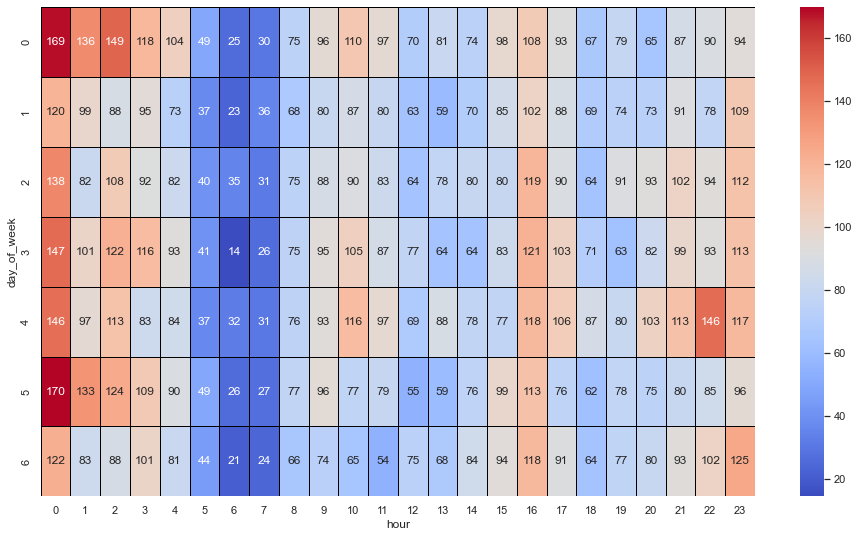

In [213]:
sns.set(rc={'figure.figsize':(16, 9)})
sns.heatmap(df_help.pivot_table(index = 'day_of_week', columns = 'hour', values = 'num_orders', aggfunc = 'mean'), 
            cmap = 'coolwarm', 
            linewidths=1, 
            linecolor='black',
            annot = True,
            fmt='.0f')

<AxesSubplot:xlabel='month', ylabel='day_of_week'>

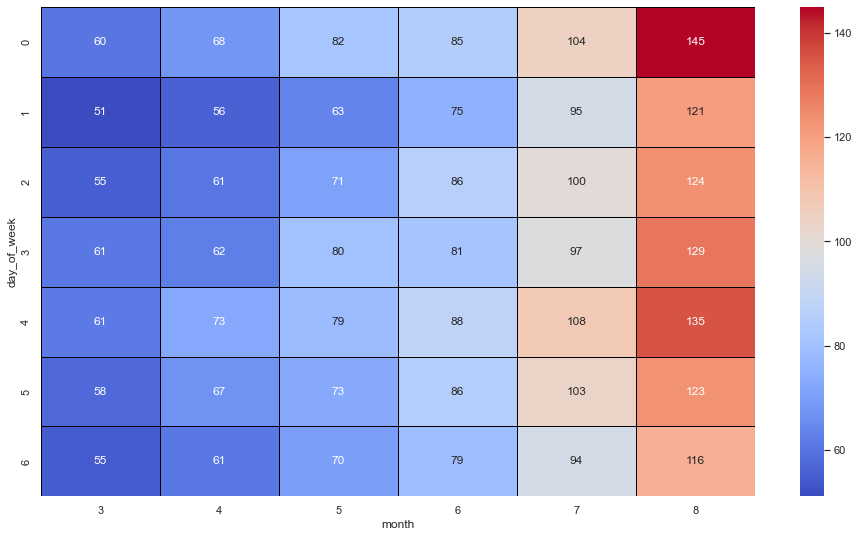

In [214]:
sns.set(rc={'figure.figsize':(16, 9)})
sns.heatmap(df_help.pivot_table(index = 'day_of_week', columns = 'month', values = 'num_orders', aggfunc = 'mean'), 
            cmap = 'coolwarm', 
            linewidths=1, 
            linecolor='black',
            annot = True,
            fmt='.0f')

Проверим ряд на стационарность с помощью формального статистического расширенного теста Дики-Фуллера (можно проверить на стационарность с учетом тренда.

* **H0** - ряд **НЕ СТАЦИОНАРЕН**
* **H1** - ряд **СТАЦИОНАРЕН**

In [215]:
# Расширенный тест Дики-Фуллера
def dickey_fuller(ts, alpha=0.05):
    
    adf_c_pvalue = adfuller(ts, regression = 'c')[1]
    print(f'P-значение теста Дики-Фуллера с константой равно {adf_c_pvalue}')
    if adf_c_pvalue < alpha:
        print(f'На уровне значимости {alpha} ряд можно считать стационарным.')
    else:
        print(f'На уровне значимости {alpha} ряд НЕЛЬЗЯ считать стационарным.')
        
    print()
    
    adf_ct_pvalue = adfuller(ts, regression = 'ct')[1]
    print(f'P-значение теста Дики-Фуллера с константой и трендом равно {adf_ct_pvalue}')
    if adf_c_pvalue < alpha:
        print(f'На уровне значимости {alpha} ряд можно считать стационарным.')
    else:
        print(f'На уровне значимости {alpha} ряд НЕЛЬЗЯ считать стационарным.')
        
    print('_'*100)

In [216]:
dickey_fuller(df['num_orders'])
dickey_fuller(df['num_orders'], 0.01)

dickey_fuller(df['num_orders'].diff().dropna())


P-значение теста Дики-Фуллера с константой равно 0.028940051402614502
На уровне значимости 0.05 ряд можно считать стационарным.

P-значение теста Дики-Фуллера с константой и трендом равно 1.258392436180182e-11
На уровне значимости 0.05 ряд можно считать стационарным.
____________________________________________________________________________________________________
P-значение теста Дики-Фуллера с константой равно 0.028940051402614502
На уровне значимости 0.01 ряд НЕЛЬЗЯ считать стационарным.

P-значение теста Дики-Фуллера с константой и трендом равно 1.258392436180182e-11
На уровне значимости 0.01 ряд НЕЛЬЗЯ считать стационарным.
____________________________________________________________________________________________________
P-значение теста Дики-Фуллера с константой равно 1.0958776746515438e-28
На уровне значимости 0.05 ряд можно считать стационарным.

P-значение теста Дики-Фуллера с константой и трендом равно 1.1927151347140948e-22
На уровне значимости 0.05 ряд можно считать ста

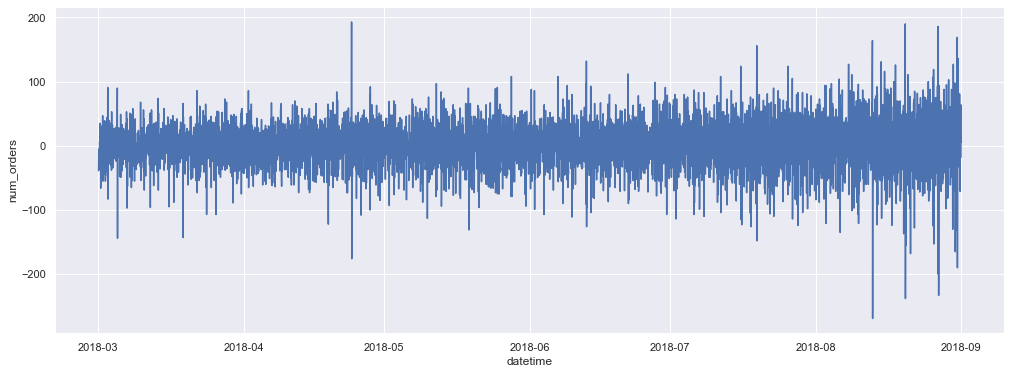

In [217]:
ts_graph(df['num_orders'].diff().dropna())

* На уровне значимости 0,05 исходный ряд стационарен только с учетом поправки на тренд
* На уровне значимости 0,01 только с учетом поправки на тренд
* Первые разности стационарны (т.е. исходный верменной ряд интегрирован первого порядка).

В ДАЛЬНЕЙШЕМ ЭТА ИНФОРМАЦИЯ ПРИГОДИТСЯ

## 3. Построение моделей

### 3.1 Подготовка данных

#### 3.1.1 Функция создания признаков

Необходимо определить какие признаки мы хотим добавить в модель.
* Стоит добавить **лаги**, поскольку в случае динамического ценообразования спрос в предыдущие периоды может повлиять на желание заказать такси в последущие периоды (например, сейчас высокий спрос, цена высокая, поэтому люди могут в ближайший час менее охотно заказывать такси)
* Стоит добавить **время суток** (как категориальный признак), поскольку может наблюдаться повышенная активность в начале и конце рабочего дня, например) :
    - Утро (06:00 - 12:00)
    - День (12:00 - 18:00)
    - Вечер (18:00 - 23:00)
    - Ночь (23:00 - 06:00)
* Стоит добавить день недели (как категориальный признак), поскольку в пт, сб и вс обычно наблюдается повышенный спрос.
* Стоит также добавить месяц, точнее время года, потомучто летом явно спрос ввыше чем весной (на графиках было показано).

In [218]:
"""
Функция на вход принимает:
1) количество желаемых лагов
2) размер окна для скользящего среднего
3) хотим ли мы добавить столбец со временем суток (Утро - 0, день - 1, вечер - 2, ночь - 3)
4) хотим ли мы добавить столбец с номером дня недели (1-пн, 2-вт, ..., 7-Вс)
5) хотим ли мы добавить столбец с временем года (Зима - 1, Весна - 2 и т. д.)
"""
def features_target_maker(data, 
                          max_lags=4, 
                          rolling_mean_size = 0,
                          time_of_day = True,
                          days_of_week = True, 
                          time_of_year = True):
    
    for lag in range(1, max_lags+1, 1):
        data['lag_' + str(lag)] = data['num_orders'].shift(lag)
    
    if rolling_mean_size != 0:
        data['rolling_mean_'+str(rolling_mean_size)] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    if time_of_day == True:
        data['time_of_day'] = data.index.hour
    
    if days_of_week == True:
        data['day_of_week'] = data.index.dayofweek+1
    
    if time_of_year == True:
        data['time_of_year'] = data.index.month
        data['time_of_year'] = data['time_of_year'].replace([12, 1, 2], 0)
        data['time_of_year'] = data['time_of_year'].replace([3, 4, 5], 1)
        data['time_of_year'] = data['time_of_year'].replace([6, 7, 8], 2)
        data['time_of_year'] = data['time_of_year'].replace([9, 10, 11], 3)
    
#     temp = pd.get_dummies(data, columns = ['time_of_day', 'day_of_week', 'time_of_year'], drop_first=True)
#     data = pd.concat([data, temp], axis=1).drop(['time_of_day', 'day_of_week', 'time_of_year'], axis=1)
    data = data.dropna()
    
    return data.drop('num_orders', axis=1), data['num_orders']
        
    

In [219]:
features, target = features_target_maker(df, 
                                         max_lags=4, 
                                         rolling_mean_size = 2, 
                                         time_of_day = True, 
                                         days_of_week = True, 
                                         time_of_year = True)

display(features.head())
display(target.head())

,lag_1,lag_2,lag_3,lag_4,rolling_mean_2,time_of_day,day_of_week,time_of_year
datetime,,,,,,,,
2018-03-01 04:00:00,66.0,71.0,85.0,124.0,68.5,4,4,1
2018-03-01 05:00:00,43.0,66.0,71.0,85.0,54.5,5,4,1
2018-03-01 06:00:00,6.0,43.0,66.0,71.0,24.5,6,4,1
2018-03-01 07:00:00,12.0,6.0,43.0,66.0,9.0,7,4,1
2018-03-01 08:00:00,15.0,12.0,6.0,43.0,13.5,8,4,1


datetime
2018-03-01 04:00:00    43
2018-03-01 05:00:00     6
2018-03-01 06:00:00    12
2018-03-01 07:00:00    15
2018-03-01 08:00:00    34
Freq: H, Name: num_orders, dtype: int64

#### 3.1.2 Тестовая и обучающая выборки

In [220]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, shuffle = False)

print("Целая выборка: {}\nОбучающая: {}\nТестовая: {}"
     .format(features.shape, x_train.shape, x_test.shape))

Целая выборка: (4412, 8)
Обучающая: (3970, 8)
Тестовая: (442, 8)


#### 3.1.3 Метрика RMSE

In [221]:
def rmse(y, predictions):
    """
    Возвращает расчёт RMSE
    y - целевой признак
    predictions - предсказания модели
    
    для расчёта RMSE использована функция 
    mean_squared_error(X, y) из библиотеки sklearn
    """
    return np.sqrt(mse(y, predictions))

rmse_score = make_scorer(rmse, greater_is_better=False)

### 3.2 Обучение моделей

In [222]:
cv = TimeSeriesSplit(n_splits=5)
rnd_st=12345

cat_columns = ['time_of_day' , 'day_of_week', 'time_of_year']

estimators = {
    'lin_reg': LinearRegression(),
    'lasso': Lasso(random_state = rnd_st),
    'dec_tree': DecisionTreeRegressor(random_state = rnd_st),
    'rand_forest': RandomForestRegressor(random_state = rnd_st),
    'lgmb_reg': LGBMRegressor(boosting_type='gbdt', random_state = rnd_st, categorical_feature = cat_columns),
    'cat_boost': CatBoostRegressor(silent=True, random_state = rnd_st, cat_features = cat_columns)
}

params = {
    'lin_reg': {},
    'lasso': {
        'alpha': np.logspace(-2, 5)
    },
    'dec_tree': {
        'max_depth': [10, 20, 50, 100]
    },
    'rand_forest': {
        'max_depth': [10, 20, 50, 100],
        'n_estimators': [5, 10, 20, 50]
        
    },
    'lgmb_reg': {
        'n_estimators': [10],
        'num_leaves': [20],
        'learning_rate': np.logspace(-2, 5)
    },
    'cat_boost': {
        'n_estimators': [60, 150, 200, 175]        
    }
}


In [223]:
best_models = []
for model in list(estimators.keys()):
    try:
        print('МОДЕЛЬ', model.upper())
        start = time.time()
        grid = GridSearchCV(estimator=estimators[model], param_grid=params[model], cv=cv, scoring=rmse_score, n_jobs=-1)
        grid = grid.fit(x_train, y_train)
        best_model = grid.best_estimator_
        preds = best_model.predict(x_train)
        print(f'Время перебора моделей: {(time.time()-start):0.2f}')
        print(f'Лучшие параметры модели: {model.upper()}: {grid.best_params_}')
        print(f'RMSE: {rmse(preds, y_train)}')
        print('_'*100)
        best_models.append(grid.best_estimator_)
    except:        
        print('МОДЕЛЬ', model.upper(), 'НЕ ОЦЕНИВАЕТСЯ')
        print('НУЖНА ПОМОЩЬ!!!')
        print('_'*100)

МОДЕЛЬ LIN_REG
Время перебора моделей: 0.03
Лучшие параметры модели: LIN_REG: {}
RMSE: 30.966390182519966
____________________________________________________________________________________________________
МОДЕЛЬ LASSO
Время перебора моделей: 0.43
Лучшие параметры модели: LASSO: {'alpha': 0.01}
RMSE: 30.96639932529284
____________________________________________________________________________________________________
МОДЕЛЬ DEC_TREE
Время перебора моделей: 0.14
Лучшие параметры модели: DEC_TREE: {'max_depth': 10}
RMSE: 17.246917540914414
____________________________________________________________________________________________________
МОДЕЛЬ RAND_FOREST
Время перебора моделей: 3.63
Лучшие параметры модели: RAND_FOREST: {'max_depth': 50, 'n_estimators': 50}
RMSE: 8.93398726568804
____________________________________________________________________________________________________
МОДЕЛЬ LGMB_REG
МОДЕЛЬ LGMB_REG НЕ ОЦЕНИВАЕТСЯ
НУЖНА ПОМОЩЬ!!!
___________________________________________

* Наилучшей моделью на обучающей выборке оказалась модель случайного леса.
* Однако все модели прошли по критерию метрики RMSE
* ОДНАКО СЛЕДУЕТ ЗАМЕТИТЬ, ЧТО НЕ УДАЛОСЬ ПОСТРОИТЬ МОДЕЛЬ ГРАДИЕНТНОГО БУСТИНГА `LGMBREGRESSION` (НЕ МОГУ ПОНЯТЬ ПРИЧИНУ ОШИБКИ **All estimators failed to fit**

### 3.3 Модель на тестовой выборке

In [224]:
print(best_models)
for model in best_models:
    print(f'RMSE модели {model} равно {rmse(model.predict(x_test), y_test)}')
    print()

[LinearRegression(), Lasso(alpha=0.01, random_state=12345), DecisionTreeRegressor(max_depth=10, random_state=12345), RandomForestRegressor(max_depth=50, n_estimators=50, random_state=12345), <catboost.core.CatBoostRegressor object at 0x0000019B86067CA0>]
RMSE модели LinearRegression() равно 55.62693696388557

RMSE модели Lasso(alpha=0.01, random_state=12345) равно 55.62890783481816

RMSE модели DecisionTreeRegressor(max_depth=10, random_state=12345) равно 56.804857264963765

RMSE модели RandomForestRegressor(max_depth=50, n_estimators=50, random_state=12345) равно 49.305780052711214

RMSE модели <catboost.core.CatBoostRegressor object at 0x0000019B86067CA0> равно 44.80161700001355



**catboost удовлетворяет критерию**

### 3.4 ARIMA модели (дополнительно)

В эконометрике существуют модели временых рядов ARIMA  [https://ru.wikipedia.org/wiki/ARIMA]
Попробуем подобрать наилучшую такую модель.

In [151]:
model = auto_arima(df['num_orders'])

In [50]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4416
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -21872.390
Date:                Thu, 04 Aug 2022   AIC                          43750.780
Time:                        17:01:31   BIC                          43769.958
Sample:                             0   HQIC                         43757.544
                               - 4416                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6232      0.010    -60.181      0.000      -0.643      -0.603
ma.L2         -0.3606      0.010    -34.896      0.000      -0.381      -0.340
sigma2      1175.6524     15.473     75.983      0.000    1145.327    1205.978
===================================================================================
Ljung-Box (L1) (Q):                  29.37   Jarque-Bera (JB):              3323.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
preds = model.predict(len(y_test))
rmse(preds, y_test)

60.90212705745103

Метрика хуже, чем в пердыдущих моделях

## Общие выводы
* В рамках проекта проанализированы почасовые данные заказов такси за полгода.
* Были выявлены особенности в сезонности, проанализирована стационарность ряда с точки зрения формального статистического теста (расширенный тест Дики-Фуллера).
* На основе этих данных были оценены различные модели предсказания количества заказов в следующий час.
* Наилучшей моделью оказалась модель линейной регрессии (правда модель `LGMBREGRESSION`, построить не удалось, по непонятным пока причинам)
* Эконометрический подход (построение модели ARIMA показал с точки зрения метрики худший результат). Однако Следует обратить внимание на то, что эти модели Лучше интепретируются.